# Connect to Google Drive

reference: https://kgptalkie.com/human-activity-recognition-using-accelerometer-data/

Archived: https://web.archive.org/web/20210118012346/https://kgptalkie.com/human-activity-recognition-using-accelerometer-data/

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, InputLayer
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import keras
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import scipy.stats as stats
!pip install mlxtend==0.16.0
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.3 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


# Set Variables for Experiment

In [ ]:
model_name = 'simple_rnn_model.h5'
classes = ['car', 'leisure', 'play', 'run_jog', 'seizure', 'sleep', 'walk']
frame_seconds = 4
hop_seconds = 4
Fs = 20
frame_size = Fs * frame_seconds 
hop_size = Fs * hop_seconds

# Load in Cleaned Dataset

In [ ]:
df = pd.read_csv(f'/content/drive/MyDrive/Smart Dog Collar/Data/03-31-2021_snapshot/cleaned_data.csv')
display(df)

FileNotFoundError: ignored

# Prepare the Data Frames


In [ ]:
def get_frames(df, frame_size, hop_size):

    N_FEATURES = df.iloc[:, :-1].shape[1]
    frames, labels = [], []

    for i in range(0, df.shape[0] - frame_size, hop_size):
        x = df['a_x'].values[i: i + frame_size]
        y = df['a_y'].values[i: i + frame_size]
        z = df['a_z'].values[i: i + frame_size]

        gx = df['g_x'].values[i: i + frame_size]
        gy = df['g_y'].values[i: i + frame_size]
        gz = df['g_z'].values[i: i + frame_size]

        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([x, y, z, gx, gy, gz])
        labels.append(label)
        
    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)

    labels = np.asarray(labels)
    return frames, labels

In [ ]:
X, y = get_frames(df, frame_size, hop_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=y)
print('X train shape', X_train.shape)    
print('y train shape', y_train.shape)
print('X test shape', X_test.shape)    
print('y test shape', y_test.shape)

NameError: ignored

# Run Model

In [ ]:
num_classes = len(classes)
model = Sequential([
    InputLayer(input_shape=X_train[0].shape),
    SimpleRNN(20, return_sequences=True),
    SimpleRNN(20, return_sequences=True),
    SimpleRNN(20, return_sequences=True),
    SimpleRNN(20),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 80, 20)            540       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 80, 20)            820       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 80, 20)            820       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense (Dense)                (None, 7)                 147       
Total params: 3,147
Trainable params: 3,147
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint = ModelCheckpoint(model_name, save_best_only=True)
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, validation_split=0.1, 
                    callbacks=[checkpoint, early_stop])

Epoch 1/100
1565/1565 [==============================] - 95s 59ms/step - loss: 0.7369 - accuracy: 0.7480 - val_loss: 0.5622 - val_accuracy: 0.7907
Epoch 2/100
1565/1565 [==============================] - 91s 58ms/step - loss: 0.5431 - accuracy: 0.7984 - val_loss: 0.5441 - val_accuracy: 0.7945
Epoch 3/100
1565/1565 [==============================] - 90s 57ms/step - loss: 0.5108 - accuracy: 0.8082 - val_loss: 0.4985 - val_accuracy: 0.8146
Epoch 4/100
1565/1565 [==============================] - 89s 57ms/step - loss: 0.4959 - accuracy: 0.8110 - val_loss: 0.5198 - val_accuracy: 0.7990
Epoch 5/100
1565/1565 [==============================] - 90s 57ms/step - loss: 0.4940 - accuracy: 0.8140 - val_loss: 0.5031 - val_accuracy: 0.8078
Epoch 6/100
1565/1565 [==============================] - 90s 58ms/step - loss: 0.5000 - accuracy: 0.8107 - val_loss: 0.5002 - val_accuracy: 0.8069
Epoch 7/100
1565/1565 [==============================] - 92s 59ms/step - loss: 0.4902 - accuracy: 0.8159 - val_loss: 0

# Model Loss and Accuracy

In [ ]:
def plot_stats(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

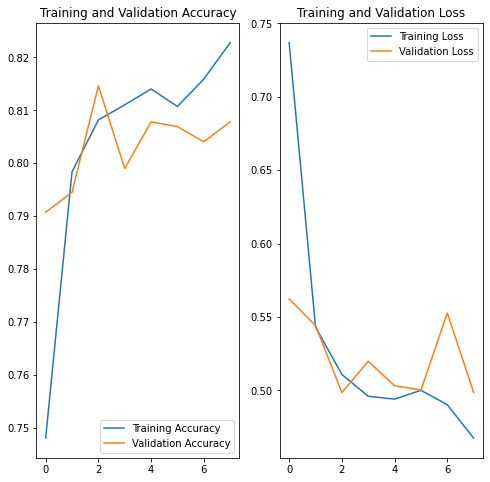

435/435 [==============================] - 26s 15ms/step - loss: 0.4817 - accuracy: 0.8164
Test Accuracy: 0.816


In [ ]:
# rollback to the best model
plot_stats(history, early_stop.stopped_epoch+1)
model = keras.models.load_model(model_name)
loss, acc = model.evaluate(X_test, y_test)
print("Test Accuracy: %.3f" % acc)

# Confusion Matrix

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fba5d53ead0>)

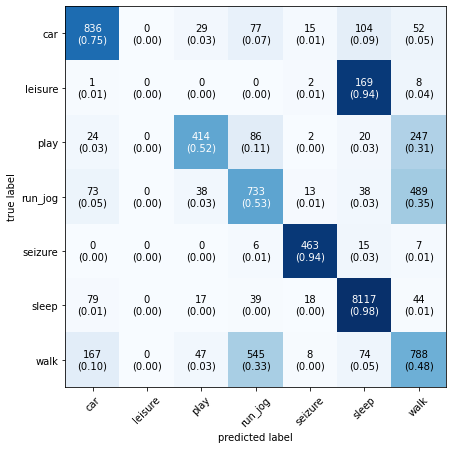

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=classes, show_normed=True, figsize=(7,7))

# Save the Model

In [ ]:
model.save(f'/content/drive/MyDrive/Smart Dog Collar/Models/{model_name}')